# Requirements

## drogue chute

Descent speed $ 22.86 m/s - 45.72 m/s $ (or $ 75 ft/s - 150 ft/s $)

## main chute

Descent speed $ v < 9.14 m/s $ (or $ v < 30ft/s $)



# Drag

Drag equation
$$
F_D = \frac{1}{2} \rho v^2 C_D A
$$

- $F_D$ drag force
- $\rho$ mass density of fluid
- $v$ velocity
- $A$ reference area
- $C_D$ drag coefficient

Descent velocity
$$
v = \sqrt{\frac{2 m g}{\rho_{air} C_D A}}
$$

In [1]:
import math

rho=1.2; # [kg/m3], at sea level 1.225, 1000m 1.121
g=9.81;

def F_drag(v, cd, d):
    A = d**2*math.pi/4
    return 1/2*rho*v**2*cd*A

def v_descent(m, cd, d):
    A = d**2*math.pi/4
    return math.sqrt(2*m*g/(rho*cd*A))

# Drogue
CFC-18: 18 inch Elliptical Parachute (from fruitychutes.com)

- Cd between 1.5 - 1.6
- Diameter: 0.46m
- Weight: 49 grams
- Materials: 1.1oz Rip-stop, 220lb nylon shroud lines, 1000lb swivel
- Number of Gores: 8
- Packing Volume: d=48mm, l=84mm, V=0.15l (assumes a very tight pack)

In [2]:
cd_drogue = 1.6 # drag coefficient
d_drogue = 0.46 # diameter [m]
v_drogue_init = v_descent(20, cd_drogue, d_drogue)
v_drogue = v_descent(18, cd_drogue, d_drogue)
print('20kg: {:.2f} m/s ({:.0f} km/h)'.format(v_drogue_init, v_drogue_init*3.6))
print('18kg: {:.2f} m/s ({:.0f} km/h) (after 2kg payload deployment)'.format(v_drogue, v_drogue*3.6))

20kg: 35.07 m/s (126 km/h)
18kg: 33.27 m/s (120 km/h) (after 2kg payload deployment)


# Main chute
IFC-84: Iris Ultra 84 inch Standard Parachute (from fruitychutes.com)

- Cd: 2.20
- Diameter: 2.13m
- Type: Toroidal (Annular)
- Packing Volume: d=100mm, l=224mm, V=1.75l (assumes a very tight pack)
- Weight 0.54 kg
- Material: Nylon
- Number of Gores: 12

In [3]:
cd_main = 2.2 # drag coefficient
d_main = 2.13 # diameter [m]
v_main = v_descent(18, cd_main, d_main)
print('18kg: {:.2f} m/s ({:.0f} km/h)'.format(v_main, v_main*3.6))

18kg: 6.13 m/s (22 km/h)


# Opening shock

The opening shock can be calculated from the drag force at deployment velocity:

$$
F_{shock} = c_x F_D = c_x \frac{1}{2} \rho v^2 C_D A
$$

using $c_x$ of 1.8

At apogee the rocket has non-zero horizontal velocity which can not be neglected.
We consider 250km/h as a worst case value.
The opening shock is approximated by the drag force of the parachute at deployment velocity.
The actual shock is assumed smaller due to the additional drag from the rocket body and the non-instantaneous deployment of the chute.

sources:
1. [Dimensionierung Bergungssystem, ARGOS (german)](http://www.argoshpr.ch/j3/articles/pdf/Recovery_Pt2.PDF)
2. [Parachute Inflation and Opening Shock, 3rd International Planetary Probe Workshop](http://solarsystem.nasa.gov/docs/06%20Parachute%20Inflation%20Wolf.pdf)

In [4]:
cx = 1.8

# deceleration shock from drogue deployment
v_apogee = 250/3.6 # [m/s] worst case lateral velocity at apogee
shock_drogue = cx * F_drag(v_apogee, cd_drogue, d_drogue)
print('drogue: {:.0f} N'.format(shock_drogue))

# deceleration shock from drogue to main chute descent velocity
shock_main = cx * F_drag(v_drogue, cd_main, d_main)
print('main: {:.0f} N'.format(shock_main))


drogue: 1385 N
main: 9370 N


## Opening shock factor for finite mass

from source 2, slide 14 & 15

In [5]:
A_main = d_main**2*math.pi/4
M = 25 # kg
mass_ratio = rho * (A_main * cd_main)**1.5/M
print('mass ratio for main parachute and 25kg: {:.3}'.format(mass_ratio))

mass ratio for main parachute and 25kg: 1.05


from the table on slide 15 we can see that this corresponds to a shock factor of about 0.1-0.2

In [6]:
cx_finite_mass = 0.2
shock_main_finite_mass_model = cx_finite_mass * F_drag(v_drogue, cd_main, d_main)
print('main shock with finite mass model (25kg): {:.0f} N'.format(shock_main_finite_mass_model))

main shock with finite mass model (25kg): 1041 N


## Opening shock numerical estimation
![title](img/Parachute_opening_shock_system.png)


movement equations
$$
m_r\ddot{y_r} = k(y_r - y_p)- m_r g
$$

$$
m_p\ddot{y_p} = \frac{1}{2}\rho C_D A \dot{y_p}^2 - k(y_r - y_p) - m_p g
$$

rewrite as first order ODE
$$
\begin{equation*}
y = \begin{bmatrix}
y_r \\
\dot{y_r}\\
y_p\\
\dot{y_p}
\end{bmatrix}
\\
\frac{\mathrm d}{\mathrm dt}y = F(y) = \begin{bmatrix}
\dot{y_r} \\
\frac{1}{m_r}k(y_r - y_p)- g \\
\dot{y_p} \\
\frac{1}{m_p}(\frac{1}{2}\rho C_D A \dot{y_p}^2) - \frac{1}{m_p}k(y_r - y_p) - g
\end{bmatrix}
\end{equation*}
$$

k = 8411.857142857143 [N/m]
schock: 3749 [N]


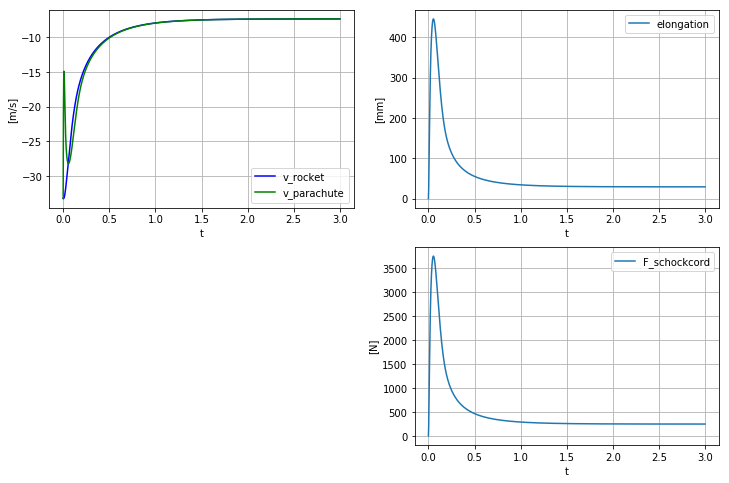

In [7]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

mp = 0.75 # [kg]
mr = 25 # [kg]

k_l = 58883 # [N], measured
l = 7 # [m] shock cord length
k = k_l/l # [N/m]

print('k = {} [N/m]'.format(k))

def F_shockcord(yr, yp):
    dl = (yp-yr)
    if dl < 0:
        return 0
    else:
        return k*dl
    
def F_drag_sign(v):
    f = F_drag(v, cd_main, d_main)
    return math.copysign(f, -v)

y0 = [0, -v_drogue, 0, -v_drogue]
def dydt(y, t):
    vr = y[1]
    Fs = F_shockcord(y[0], y[2])
    ar = 1/mr*Fs - g
    vp = y[3]
    Fd = F_drag_sign(y[3])
    ap = 1/mp*Fd - 1/mp*Fs - g
    return [vr,ar,vp,ap]

t = np.linspace(0,3,1000)
sol = odeint(dydt, y0, t)
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.plot(t, sol[:,1], 'b', label='v_rocket')
plt.plot(t, sol[:,3], 'g', label='v_parachute')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('[m/s]')
plt.grid()


plt.subplot(222)
plt.plot(t, (sol[:,2]-sol[:,0])*1000, label='elongation')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('[mm]')
plt.grid()

plt.subplot(224)
fn = np.vectorize(lambda n: F_shockcord(sol[n][0], sol[n][2]))
fs = fn(np.array(range(len(t))))
plt.plot(t,fs, label='F_schockcord')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('[N]')
plt.grid()

print('schock: {:.0f} [N]'.format(max(fs)))
plt.show()

